# Pytorch session 2 - testing GPU

## Outline
1. Introduction to `torch.nn`, `torch.nn.Module`
2. Building a simple network using `torch.linear`
3. Basic use of `torch.optim`
3. Building a simple CNN


In this session we will walk through the steps for creating artificial neural networks and Convolutional Neural Networks (ANNs and CNNs) using tools built-in to PyTorch. This largely follows [PyTorch's ``nn.Module`` tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) as well as this [pytorch mnist tutorial on kaggle](https://nextjournal.com/gkoehler/pytorch-mnist). 

The dataset we use is the **MNIST** hand-written digits dataset. This consists of black-and-white images of hand-drawn digits between 0 and 9. It is often referred to as the "hello world" of machine learning. 

In [2]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torchvision
from torch import nn

In [4]:
# MNIST_data = torchvision.datasets.MNIST('./data/MNIST_torch',download =True,)
# data_loader = torch.utils.data.DataLoader(MNIST_data,                            
#                                           batch_size=4,
#                                           shuffle=True,
#                                           num_workers=2)

In [5]:
# create directory and download MNIST if not already present
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

ConnectionError: HTTPConnectionPool(host='deeplearning.net', port=80): Max retries exceeded with url: /data/mnist/mnist.pkl.gz (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x141bcedc0>: Failed to establish a new connection: [Errno 60] Operation timed out'))

First we load the data and split it into train/valid sets. As the names suggest, the train set is used for training the model, and the validation set is used to quantify model performance. In the real world we care about how our model performs on unseen data, so the validation set is not used during training. 

The training set contains 40,000 samples and the validation/test set contains 10,000 for an 80/20 split.

Note that the words "validation" and "test" are used interchangeably here, but strictly speaking they refer to different things. [This website](https://machinelearningmastery.com/difference-test-validation-datasets/) is a good starting point if you're unsure about the difference.

In [6]:
import pickle

with open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

FileNotFoundError: [Errno 2] No such file or directory: 'data/mnist/mnist.pkl.gz'

Let's plot one example to see what the data actually looks like. 

true label:  5


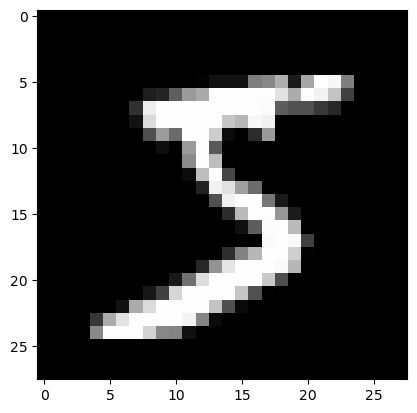

In [7]:
# plot one example 
plt.imshow(x_train[0].reshape((28, 28)), cmap = "gray");
print("true label: ", y_train[0].item())

In [8]:
# before we can work with them, they need to be converted
# into torch.tensors

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid))

n, c = x_train.shape


print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Using ```nn.Module``` 

Instead of defining all the mathematical operations ourself, like we did in tutorial 1 as

```
def classification_model(x):
    # calculate as before
    h =  w @x.t()+ b
 
    # add on a sigmoid activation function
    y = 1 / (1 + torch.exp(-h))

    return y
```

Let's define a `model` based on the ```nn.Module``` class. This is the base class for all neural network modules ([official documentation](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)), so anything we define on top of this will automatically inherit all the nice built-in functions. 

Two very useful functions are 
1. ```model.eval()``` i.e. ```nn.Module.eval() ```
2. ```model.forward()```

We can call ```model.eval()``` to put the model into evaluation mode and automatically freeze all of the weights. 

We will first build our model and incrementally add inbuilt `torch.nn` functions and modules

First, we use ```nn.Parameter``` to define the weights and biases. This tells the model that these are its parameters (`requires_grad` is set to `True` by default) - this becomes useful when doing back propagation, as we can iterate through all the parameters instead of needing to explicitly update each one. 


In [1]:
class Mnist_Logistic(nn.Module):
    # __init__ contains the setup/architecture of the model
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / np.sqrt(784))# requires_grad is set to true by default
        self.bias = nn.Parameter(torch.zeros(10))
        
    # forward tells the model what to compute when we feed inputs in
    def forward(self, x):
        return x @ self.weights + self.bias

NameError: name 'nn' is not defined

Since the model is now defined as a class, we need to instantiate the model. 

Let's choose the cross entropy from ```torch.nn.functional``` (F). This is a generalised version of binary cross entropy so that it can deal with multiple output variables.

>*``torch.nn.functional`` contains all the operations or building blocks we might need when we construct our own networks - things like convolution or pooling. All details in Pytorch documentation [here](https://pytorch.org/docs/stable/nn.functional.html#)*

In [10]:
model = Mnist_Logistic()
loss_fn = F.cross_entropy

In [11]:
# do one gradient calculation as before
loss = loss_fn(model(x_train), y_train)
loss.backward()

This is how we updated the weights before, but for more complex models this gets cumbersome as we would need to update each weight individually. 

```with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()```
    
With the help of ```nn.Parameter```, we can now iterate through all the parameters (weights and biases etc.) to update them without the need to explicitly write out each one individually. 

In [12]:
lr = 0.5

with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

Remember that the training set contains 40,000 samples and the validation/test set contains 10,000 for an 80/20 split. Since these are fairly large numbers, we might run into memory problems if we try to load all of them at once. 

We solve this by training and testing in small batches of predetermined ```batch_size```. In general, the larger the batch size, the more representative each batch will be for the entire population, and therefore the more similar batches will be to each other, allowing a smoother training process. 

This is one of the many hyperparameters we need to give the model. Other essential ones include the learning rate and the number of epochs to train for, which we covered in the previous session. 

Choosing what hyperparameters to use is more of an art than an exact science, though you will naturally get a grasp on what to use as you gain more experience. 

A training loop now looks like this - we have wrapped it inside the ```fit()``` function to be used later.

In [ ]:
# define some hyperparameters to tell the model 
lr = 0.5
num_epochs = 10
train_size = n
batch_size = 10000
losses_storage = []

model = Mnist_Logistic()
loss_fn = F.cross_entropy

def fit():

    for epoch in range(num_epochs):
        for i in range((train_size - 1) // batch_size + 1):   
            start_i = i * batch_size
            end_i = start_i + batch_size
            x_batch = x_train[start_i:end_i]
            y_batch = y_train[start_i:end_i]
            
            
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
            losses_storage.append(loss.item())

fit()

In [14]:
(train_size - 1) // batch_size + 1
print(train_size, batch_size)
for i in range(3): print(i)

np.array([[1,2],[3,1],[2,2]]).shape

(6-3)+1

50000 10000
0
1
2


4

**Task:** The process of loading data and splitting it into batches can be further siplified using [Dataset](https://pytorch.org/tutorials/beginner/nn_tutorial.html#refactor-using-dataset) and 
[DataLoader](https://pytorch.org/tutorials/beginner/nn_tutorial.html#refactor-using-dataloader), explore them.

## Using nn.Linear

```nn.Linear``` gives us a fully connected layer (each input neuron is connected to each output neuron, where each neuron is just a number) which is the basic building block of artificial neural networks (ANNs). Below we have defined an ANN with a single layer going straight from inputs to outputs to use for MNIST classification. 

![MNIST ANN](https://ml4a.github.io/images/figures/mnist_1layer.png)

In [15]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(
            in_features = 784, 
            out_features = 10
        )
        
    def forward(self, x):
        return self.linear(x)

In [16]:
model = Mnist_Logistic()
print(loss_fn(model(x_train), y_train))

tensor(2.3221, grad_fn=<NllLossBackward0>)


In [17]:
lr = 0.5
num_epochs = 10
train_size = n
batch_size = 10000
losses_storage = []

fit()

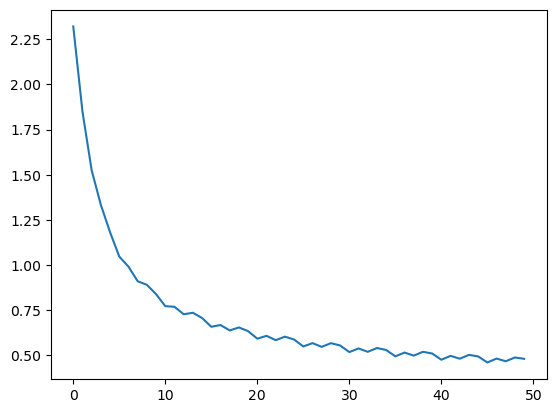

In [18]:
plt.plot(losses_storage)

As the loss levels off, it starts to fluctuate. This indicates that the model is overfitting - it is learning the noise/small deviations that are naturally present within the data. This is of course particular to each individual sample and each batch of samples. The fluctuation is caused by different batches having different quirks and pulling the model weights in different directions. 

In general we want to stop training when the training loss shows signs of overfitting (fluctuation) and the validation loss stops improving, signalling that the model has been saturated. 

### Optimizers

Optimizers exist so we do not have to manually update the parameter/weights and pytorch has the popular ones already implemented. This is especially useful when we want to use something more complex than standard gradient descent, e.g. stochastic gradient descent (SGD), RMSprop, Adam, etc... [Refer here](https://ruder.io/optimizing-gradient-descent/index.html) for an overview by Sebastian Ruder. List of available algorithms is [here](https://pytorch.org/docs/stable/optim.html#algorithms).


In [19]:
from torch import optim

we can use ``optim`` to replace the previously manually coded gradient update

``with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
``

In [20]:
# we'll be using SGD for this example

model = Mnist_Logistic()
opt = optim.SGD(model.parameters(), lr=lr)

print(loss_fn(model(x_train), y_train))

tensor(2.3366, grad_fn=<NllLossBackward0>)


In [21]:
# run model

lr = 0.5
num_epochs = 10
train_size = n
batch_size = 10000
losses_storage = []


for epoch in range(num_epochs):
    for i in range((train_size - 1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        x_batch = x_train[start_i:end_i]
        y_batch = y_train[start_i:end_i]
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)

        loss.backward()
        # this is the only difference
        opt.step()
        opt.zero_grad()
        
        losses_storage.append(loss.item())

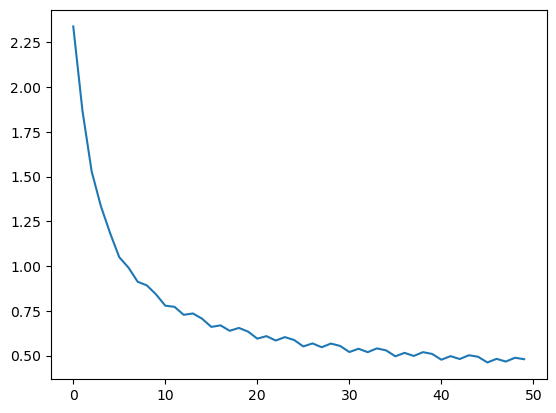

In [22]:
plt.plot(losses_storage)

# Implementing CNN

![CNN architecture](https://codetolight.files.wordpress.com/2017/11/network.png?w=1108)

Code based on https://nextjournal.com/gkoehler/pytorch-mnist, image from [here](https://codetolight.wordpress.com/2017/11/29/getting-started-with-pytorch-for-deep-learning-part-3-neural-network-basics/).

Convolutional Neural Networks (CNNs) is a very popular choice when it comes to image processing. As the name suggests, it is based on the convolution operation which is perhaps best explained using an animation (from [an intuitive explanation of CNNs](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/)). Essentially we are sliding a filter (matrix) over the input, and the sum of the element-wise product forms the output. 

![cnn anim](https://ujwlkarn.files.wordpress.com/2016/07/convolution_schematic.gif?w=268&h=196)

At each layer there are often multiple filters. The idea is that they will be able to independently learn different "features" of images, and when combined facilitate a better overall understanding of the image. As we go from earlier layers to later layers, the features that the filters look for become more high-level. For natural images they might start by looking for straight edges or curves, then circles and squares, and ultimately cat noses etc. 

This is coupled with some sort of a pooling operation, which once again decreases the size of the input. Common ones include max pooling and average pooling, which return the maximum and average of the input varues respectively. 

![max pool](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)

When designing a CNN, it is very important to track the dimensions of the input at each stage and how it gets altered by each operation, so that the layers will correctly stack on top of each other. 

We start with 28x28x1 inputs since each image is 28x28 pixels with only one channel (greyscale). With natural images it is more common to see three separate channels (RGB). While in general the inputs will be width x height x channels, pytorch has the convention 

> **`batch x channels x height x width`**. 

<img src="./numpy_nd_array.png" width = 400> </img>

We define a simple 2-layer CNN below, where each layer consists of (convolution->pooling->non-linear). Remember that the non-linearity is required as otherwise the whole network would just simplify down to a single linear operation! You can read up on ReLU [here](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) and softmax [here](https://machinelearningmastery.com/softmax-activation-function-with-python/). Log softmax, as the name implies, is the log of softmax which gives us some nice statistical and computational properties. 

For classification, we add two final dense (fully connected) layers on top of the CNN to add as the classifier. In contrast, the CNN can be seen as a feature exatractor which tells us whether a circle or a line is present in the image, and if so where are they located and how are they oriented? The classifier then learns that a circle connected on its right to a downward line represents a 9, etc. 

The network architecture looks like this:

<img src="CNN_arch.jpg" width=800 >


Follow along the comments and make sure you understand how we go from one set of dimensions to the next.

In [23]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels = 1,
            out_channels = 10,
            kernel_size = 5
        )
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):        
        x = self.conv1(x)           # convolution: dim = 24x24x10
        x = F.max_pool2d(x, 2)      # max pool with kernel size 2: d = 12x12x10
        x = F.relu(x)               # non-lineararity
        
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) # dim = 4x4x20 = 320
        
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [24]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import torch.nn.functional as F
# import torch
# import torchvision
# from torch import nn
lsm  = nn.LogSoftmax( dim=1)
sm = nn.Softmax(dim=1)
mat = torch.randn(2, 3)
output = lsm(mat)
print(mat, '\n', output)

output = sm(mat)
print(mat, '\n', output)

tensor([[-0.5556,  1.9750, -0.7026],
        [-0.3055, -1.6633, -0.5889]]) 
 tensor([[-2.6689, -0.1383, -2.8159],
        [-0.6983, -2.0562, -0.9818]])
tensor([[-0.5556,  1.9750, -0.7026],
        [-0.3055, -1.6633, -0.5889]]) 
 tensor([[0.0693, 0.8708, 0.0599],
        [0.4974, 0.1279, 0.3746]])


Good reference for convolution layer size is [here](https://arxiv.org/pdf/1603.07285.pdf)

In [25]:
# define hyperparameters to use as before 

num_epochs = 3
batch_size = 64
lr = 0.01
log_interval = 10

# get the model and optimiser
model = CNN()
opt = optim.SGD(model.parameters(), lr = lr)

losses_storage = []

In [26]:
def train():
    model.train()
    for i in range(train_size // batch_size):
        start_i = i * batch_size
        end_i = start_i + batch_size
        x_batch = x_train[start_i:end_i]
        y_batch = y_train[start_i:end_i]
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)

        loss.backward()
        opt.step()
        opt.zero_grad()
        
        if i % log_interval == 0:
            losses_storage.append(loss.item())

For CNNs it is important that we preserve the spatial layout of the pixels since the operations (namingly convolution and pooling) work on patches of adjacent pixels. Previously for the ANN we simply passed the input as a 784-dimensional vector, but here we will need to transform them into 28x28x1 tensors. 

In [27]:
x_train = x_train.view(-1, 1, 28, 28) # [batch_size, channels, height, width]
x_valid = x_valid.view(-1, 1, 28, 28)

In [28]:
# try training for one epoch to test that it works

train()
print(losses_storage[-1])

0.4483864903450012


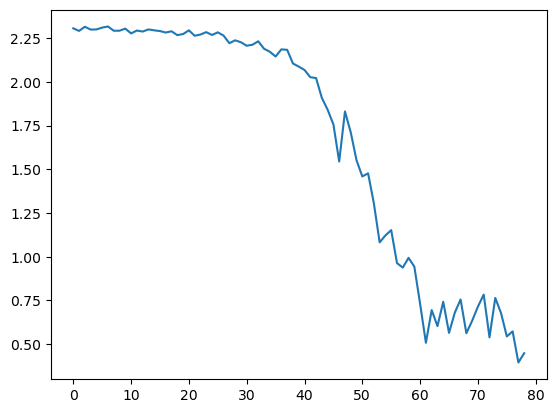

In [29]:
plt.plot(losses_storage)


In [30]:
# define a function to test model performance on a test set
# the test set is not seen during training 

test_losses = []
test_accs = []
test_size = x_valid.shape[0]
batch_size_test = 1000
predictions = []

def test():
    predictions = []
    model.eval()
    with torch.no_grad():
        for i in range(test_size // batch_size_test):
            start_i = i * batch_size_test
            end_i = start_i + batch_size_test
            x_batch = x_valid[start_i:end_i]
            y_batch = y_valid[start_i:end_i]
            
            out = model(x_batch)
            loss = loss_fn(out, y_batch)
            test_losses.append(loss.item())
            
            pred = out.max(1)[1]
            acc = (sum(pred.eq(y_batch))/len(y_batch))
            test_accs.append(acc.item())
            predictions.append(pred)
               
    print("Test set average loss: {:.4f}".format(np.mean(test_losses)))
    print("Test set average accuracy: {:.4f}".format(np.mean(test_accs)))    
    
    return np.stack(predictions).ravel()

In [31]:
# test to see if it works
preds = test()

Test set average loss: 0.5428
Test set average accuracy: 0.8191


In [32]:
%%time
# try putting it all together and training for 3 epochs


num_epochs = 3
batch_size = 64
lr = 0.01
log_interval = 10

model = CNN()
opt = optim.SGD(model.parameters(), lr = lr)

losses_storage = []

for e in range(1, num_epochs + 1):
    train()
    predictions = test()

Test set average loss: 0.5119
Test set average accuracy: 0.8331
Test set average loss: 0.4392
Test set average accuracy: 0.8586
Test set average loss: 0.3826
Test set average accuracy: 0.8778
CPU times: total: 1min 43s
Wall time: 17.3 s


Sometimes we see loss plotted against the number of samples seen or the number of training steps (number of batches seen during training) instead of epoch. This is useful when we train for few epochs but with a lot of data. 

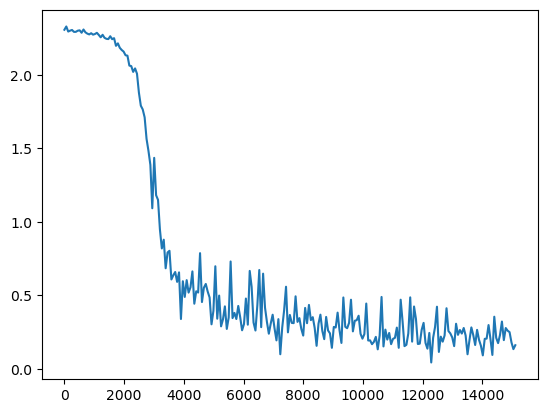

In [33]:
num_samples_seen = batch_size*np.arange(len(losses_storage))
plt.plot(num_samples_seen, losses_storage)

Finally let's have a look at the CNN predictions. Given the test accuracy we calculated above, we are expecting fairly accurate predictions. You can run the following code several times to generate a few different samples. 

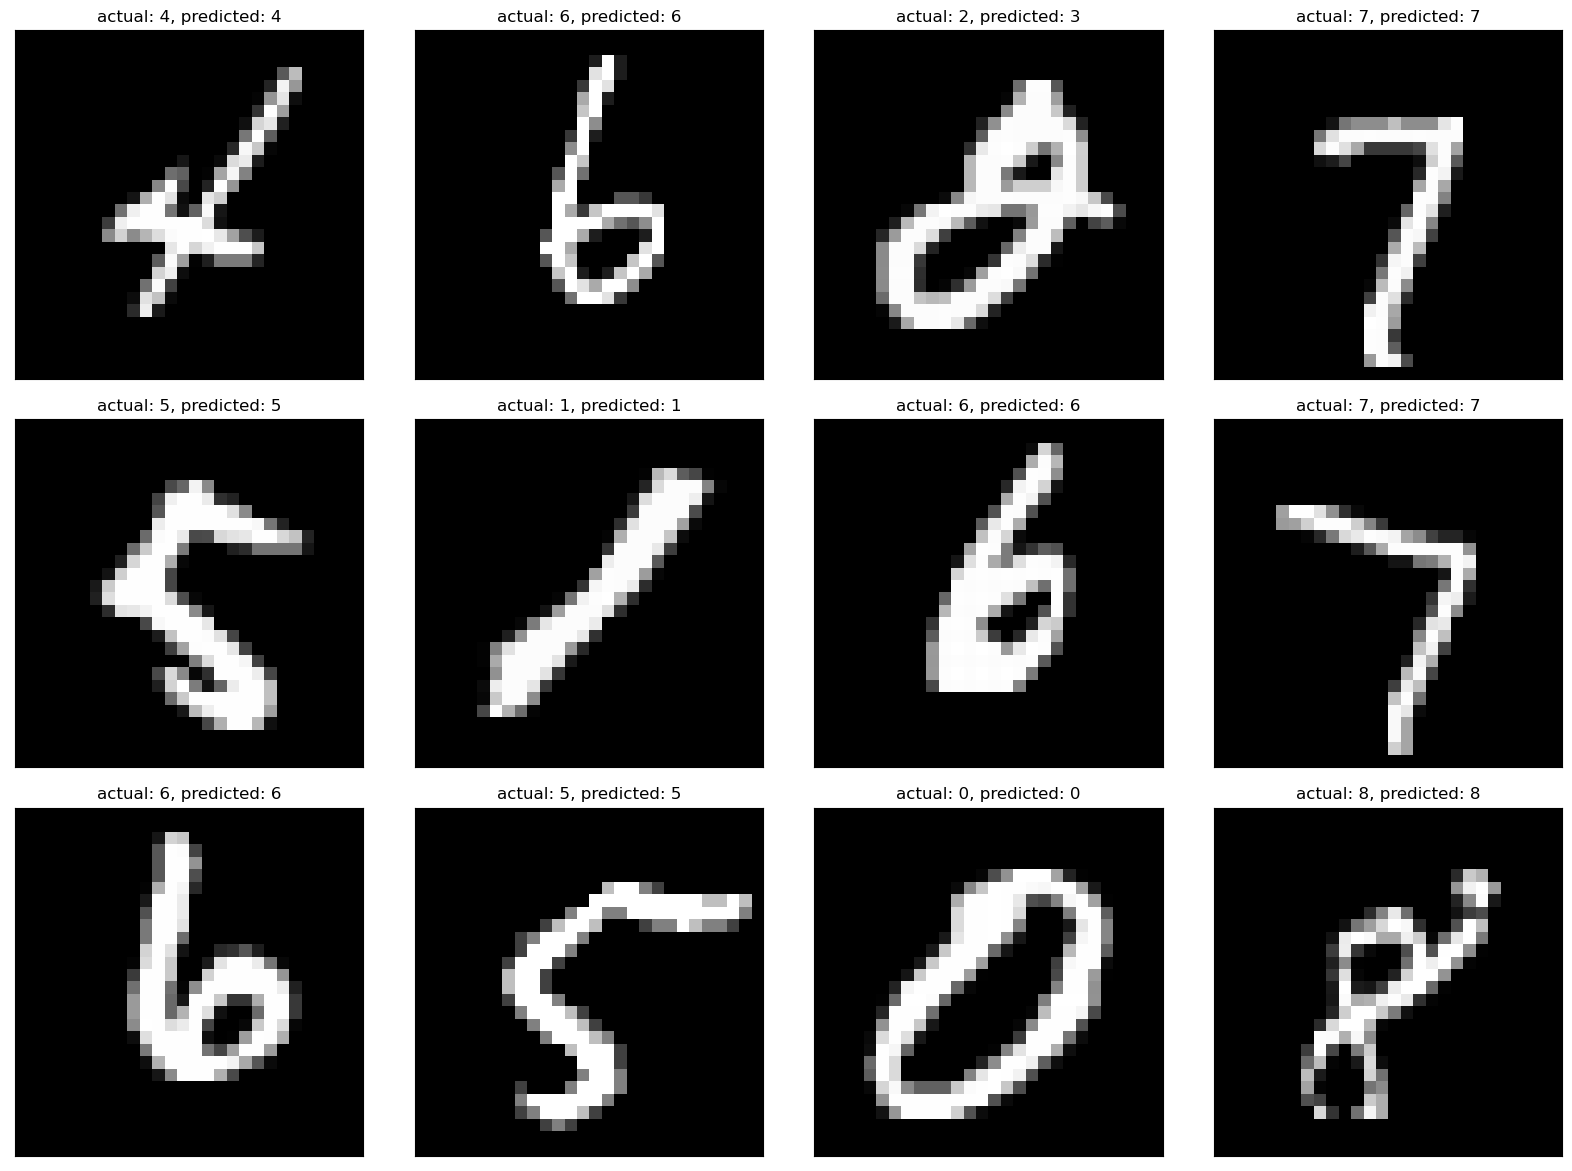

In [34]:
examples = np.random.randint(low = 0, high = len(y_valid) - 1, size = 12)
y_examples = y_valid[examples]
pred_examples = predictions[examples]
x_examples = x_valid[examples]

fig = plt.figure(figsize = (16, 12))

for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.imshow(x_examples[i, 0], cmap = "gray")
    plt.title(
        "actual: {}, predicted: {}".format(y_examples[i], pred_examples[i])
    )

    plt.xticks([])
    plt.yticks([])

# Additional resources
pytorch nn.module tutorial - https://pytorch.org/tutorials/beginner/nn_tutorial.html

kaggle mnist tutorial - https://nextjournal.com/gkoehler/pytorch-mnist

optimizers overview - https://ruder.io/optimizing-gradient-descent/index.html

MNIST CNN tutorial https://nextjournal.com/gkoehler/pytorch-mnist

#### Notes

In [35]:
m = nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)

# The above model modifed to run using GPU

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Check if GPU is available
print(device)
modelGPU = model.to(device) # Convert defined model to GPU

cuda


In [37]:
torch.cuda.is_available()

True

In [38]:
def trainGPU():
    model.train()
    for i in range(train_size // batch_size):
        start_i = i * batch_size
        end_i = start_i + batch_size
        x_batch = x_train[start_i:end_i].to(device) # Move data to gpu
        y_batch = y_train[start_i:end_i].to(device)
        pred = modelGPU(x_batch)
        loss = loss_fn(pred, y_batch)

        loss.backward()
        opt.step()
        opt.zero_grad()
        
        if i % log_interval == 0:
            losses_storage.append(loss.item())

In [39]:
# define a function to test model performance on a test set
# the test set is not seen during training 

test_losses = []
test_accs = []
test_size = x_valid.shape[0]
batch_size_test = 1000
predictions = []

def testGPU():
    predictions = []
    model.eval()
    with torch.no_grad():
        for i in range(test_size // batch_size_test):
            start_i = i * batch_size_test
            end_i = start_i + batch_size_test
            x_batch = x_valid[start_i:end_i].to(device) # Move data to gpu
            y_batch = y_valid[start_i:end_i].to(device)
            
            out = modelGPU(x_batch)
            loss = loss_fn(out, y_batch)
            test_losses.append(loss.item())
            
            pred = out.max(1)[1]
            acc = (sum(pred.eq(y_batch))/len(y_batch))
            test_accs.append(acc.item())
            predictions.append(pred.detach().clone().cpu().numpy())
               
    print("Test set average loss: {:.4f}".format(np.mean(test_losses)))
    print("Test set average accuracy: {:.4f}".format(np.mean(test_accs)))    
    
    return np.stack(predictions).ravel()

In [40]:
%%time
# try putting it all together and training for 3 epochs

num_epochs = 3
batch_size = 64
lr = 0.01
log_interval = 10


opt = optim.SGD(model.parameters(), lr = lr)

losses_storage = []

for e in range(1, num_epochs + 1):
    trainGPU()
    predictions = testGPU()

Test set average loss: 0.1656
Test set average accuracy: 0.9501
Test set average loss: 0.1513
Test set average accuracy: 0.9547
Test set average loss: 0.1405
Test set average accuracy: 0.9577
CPU times: total: 7.39 s
Wall time: 8.06 s
